#  Unsupervised learning addition model

Author: S. Menary [sbmenary@gmail.com]

Date: 5/4/2023  (last update: 5/4/2023)

Overview: Train a `sequence -> sequence` model where the input sequence is a text representation of a simple sum $A \pm B$ for integers $A,B\in\mathbb{Z}\left([-N,~N]\right)$ for some maximum-amplitude $N$, and the output is a text representation of the answer. Since the output is a numerical value, the loss function is a sparse categorical entropy

---

## 1. Set up program

###  Import

All imports go here at the top of the notebook

In [1]:
##=========================##
##   All imports go here   ##
##=========================##

##  Import entire python stdlib packages
import datetime, json, logging, math, os, pickle, random, sys, time

##  Import entire pypi packages
import matplotlib as mpl
import numpy      as np
import tensorflow as tf

##  Import individual modules/objects from python stdlib packages
from pathlib import Path

##  Import individual modules/objects from pypi packages
from tensorflow.keras.callbacks  import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers     import Average, Concatenate, Dense, Embedding, Input, Layer, Masking
from tensorflow.keras.losses     import SparseCategoricalCrossentropy
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from matplotlib                  import pyplot as plt

##  Add directory above this to system path to expose mathsformer package location
sys.path.append("/".join(os.getcwd().split("/")[:-1]))

##  Import individual modules/objects from local packages
from mathsformer.data       import add_positions_to_sequences, detokenise_string, detokenise_strings, strings_to_tensor, tokenise_strings
from mathsformer.tf_objects import (create_custom_objects_dict, get_nested_sublayers, masked_accuracy, 
                                    masked_sparse_categorical_crossentropy, AttentionBlock, DecoderBlock, 
                                    EncoderBlock, Enumerate, FeedForwardBlock, LayerActivationRecord, LayerWeightsRecord, 
                                    LoggerCallback, MetricRecord, PositionalEncoding, ReduceSequence, RightSlice)
from mathsformer.utils      import create_working_directory, fancy_message, initialise_program, log_versions, summarise_dict


### Configuation

Set global configuration variables

In [2]:
##===================##
##   Global config   ##
##===================##


##  Set log levels for logging streams to notebook and to log file in working directory
log_lvl_iostream = logging.INFO
log_lvl_fstream  = logging.DEBUG


##  Create dictionary of config values
##  -  config values to be set here and never changed!
##  -  use nested dictionary as a proxy for namespacing
##  -  e.g. can access data config value like config["data"]["label_prescale"]
global_config = {
    "base_seed"         : -1,
    "working_directory" : "unsupervised_learning_addition_model_[tag]_[date]_[time]",
    "tag"               : "LARGE",
    "data" : {
        "max_int"        : 99,
        "char_tokens"    : ['M', 'B', 'E', 'N', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-'],
        "mask_char"      : 'M',
        "seq_start_char" : 'B',
        "seq_end_char"   : 'E',
        "negative_char"  : 'N',
        "test_split_idx" : 0.05,
        "val_split_idx"  : 0.2,
        "dtype"          : "int32",
    },
    "model" : {
        "load_pretrained_model" : "",
        "ndim_model"            : 32,
        "ndim_embedding"        : 16,
        "num_freqs"             : 8,
        "min_period"            : 4,
        "max_period"            : 200,
        "num_pre_layers_encoder": 1,
        "ndim_pre_layers"       : 128,
        "num_encoder_layers"    : 3,
        "num_heads"             : 8,
        "ndim_att_hidden"       : 32,
        "ndim_ff_hidden"        : 128,
        "num_pre_layers_decoder": 1,
        "num_decoder_layers"    : 3,
        "num_post_layers"       : 2,
        "ndim_post_layers"      : 128,
        "dropout"               : 0.1,
        "learning_rate"         : 1e-3,
        "dtype"                 : "float32"
    },
    "training" : {
        "train"                   : True,
        "max_epochs"              : 1000,
        "batch_size"              : 32,
        "early_stopping"          : True,
        "early_stopping_patience" : 2,
        "layer_activation_record_batch_frequency" : 100, 
        "layer_activation_record_max_datapoints"  : 32, 
        "layer_weights_record_batch_frequency" : 100, 
        "layer_weights_record_recursive"       : True, 
        "loss_record_batch_frequency" : 100, 
        "loss_record_max_datapoints"  : 256, 
        "loss_record_num_bootstrap"   : 20, 
        "loss_record_plot_frequency"  : 2, 
    },
    "evaluate" : {
        "num_bootstrap" : 100,
        "num_print"     : 40,
    },
}


##  Report success
print(fancy_message(f"Created global_config"))

===   Created global_config   ===


###  Validate config

Look for some obvious confguration errors. WARNING: This is not an exhaustive search and can't be replied upon to catch all misconfigurations!

In [3]:
##===============================##
##   Global config - continued   ##
##===============================##

def validate_config(config) :
    """Raise exceptions in the case of program misconfigurations"""
    mask_char      = global_config["data"]["mask_char"]
    seq_start_char = global_config["data"]["seq_start_char"]
    seq_end_char   = global_config["data"]["seq_end_char"]
    negative_char  = global_config["data"]["negative_char"]
    char_tokens    = global_config["data"]["char_tokens"]
    
    ##  Check that only single character tokens are provided
    for char_token in char_tokens :
        if len(char_token) == 1 : continue
        raise ValueError(f"All character tokens must be single characters but '{char_tokens}' found")
        
    ##  Check mask character is provided
    if len(mask_char) != 1 :
        raise ValueError(f"Mask character must be a single character but '{mask_char}' provided")
        
    ##  Check mask character in character list
    if mask_char not in char_tokens :
        raise ValueError(f"Mask character '{mask_char}' not found in character list: {char_tokens}")
    
    ##  Check that mask character is first in char_tokens list (ensures it's assigned a token of 0)
    if char_tokens[0] != mask_char :
        raise ValueError(f"Mask character '{mask_char}' must be the first in the char_tokens list provided, "
                        +f"instead found list: {char_tokens}")
        
    ##  Check seq_start_char character is provided
    if len(seq_start_char) != 1 :
        raise ValueError(f"Sequence start character must be a single character but '{seq_start_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_start_char not in char_tokens :
        raise ValueError(f"Sequence start character '{seq_start_char}' not found in character list: {char_tokens}")
        
    ##  Check seq_end_char character is provided
    if len(seq_end_char) != 1 :
        raise ValueError(f"Sequence end character must be a single character but '{seq_end_char}' provided")
        
    ##  Check seq_start_char character in character list
    if seq_end_char not in char_tokens :
        raise ValueError(f"Sequence end character '{seq_end_char}' not found in character list: {char_tokens}")
        
    ##  Check negative_char character is provided
    if len(negative_char) != 1 :
        raise ValueError(f"Negative symbol character must be a single character but '{negative_char}' provided")
        
    ##  Check negative_char character in character list
    if negative_char not in char_tokens :
        raise ValueError(f"Negative symbol character '{negative_char}' not found in character list: {char_tokens}")
        
    ##  If here then config validated correctly
    print(fancy_message("Config successfully validated"))
    
validate_config(global_config)

===   Config successfully validated   ===


##  2. Set up environment

- Create working directory
- Create logger
- Log package versions for reproducibility
- Log config values for reproducibility
- Set random seeds for reproducibility


In [4]:
##==============================##
##   Create working directory   ##
##==============================##

##  Report success
working_dir = global_config["working_directory"]
working_dir, logger, base_seed, np_seed, tf_seed = initialise_program(
    "unsupervised_learning_model notebook", 
    working_dir, 
    global_config
)


===   Working directory created at unsupervised_learning_addition_model_LARGE_2023_04_08_125654   ===
   INFO  Begin logging on 2023-04-08 at 12:56:54
   INFO  Program description: unsupervised_learning_model notebook
   INFO  Working directory: unsupervised_learning_addition_model_LARGE_2023_04_08_125654
   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                               PACKAGE  |  VERSION
   INFO  ------------------------------------------------------+----------------------------------------------------------------------------------
   INFO                                                Python  |  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
   INFO                                               IPython  |  8.7.0
   INFO                                  IPython.core.release  |  8.7.0
   INFO                           

   INFO                                    urllib3.connection  |  1.26.13
   INFO                                  urllib3.packages.six  |  1.16.0
   INFO                       urllib3.util.ssl_match_hostname  |  3.5.0.1
   INFO                                        requests.utils  |  2.28.1
   INFO                                            setuptools  |  65.6.3
   INFO                                             distutils  |  3.10.8
   INFO                     setuptools._vendor.more_itertools  |  8.8.0
   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging  |  21.3
   INFO                setuptools._vendor.packaging.__about__  |  21.3
   INFO                          setuptools._vendor.pyparsing  |  3.0.9
   INFO                     setuptools._vendor.more_itertools  |  8.8.0
   INFO                        setuptools._vendor.ordered_set  |  3.1
   INFO                          setuptools._vendor.packaging 

##  3. Create training data

###  Generate string-string pairs

In [5]:
##=====================##
##   Create raw data   ##
##=====================##

def generate_raw_dataset(max_int:int=999, include_neg:bool=True, shuffle:bool=True, negative_char:str='N') :
    '''
    Create dataset where input is str of "A+B" or "A-B", and output is str containing the answer
    A and B are positive or negative integers with maximum amplitude given
    '''
    logger.info(f"generate_raw_dataset(): called with max_int={max_int:,}, include_neg={include_neg}, shuffle={shuffle}")
    if include_neg : singles = np.arange(-max_int, max_int+1, dtype=np.int32) 
    else           : singles = np.arange(0       , max_int+1, dtype=np.int32)
    pairs   = np.array([[(x,y) for x in singles] for y in singles])
    pairs   = np.concatenate(pairs)
    summed  = pairs[:,0] + pairs[:,1]
    minus   = pairs[:,0] - pairs[:,1]
    dataset = []
    for (i1, i2), s, m in zip(pairs, summed, minus) :
        i1, i2 = f"{i1}".replace("-",negative_char), f"{i2}".replace("-",negative_char)
        s , m  = f"{s }".replace("-",negative_char), f"{m }".replace("-",negative_char)
        dataset.append((f"{i1}+{i2}", f"{s}"))
        dataset.append((f"{i1}-{i2}", f"{m}"))
    np.random.shuffle(dataset)
    logger.info(f"generate_raw_dataset(): created dataset with length {len(dataset):,}")
    return dataset


In [6]:
##=================================##
##   Create raw data - continued   ##
##=================================##

start_time   = time.time()
max_int      = global_config["data"]["max_int"]
raw_dataset  = generate_raw_dataset(max_int)
max_X_length = max([len(s[0]) for s in raw_dataset])
max_Y_length = max([len(s[1]) for s in raw_dataset])

logger.info(f"Created {len(raw_dataset):,} datapoints in {time.time()-start_time:.1f}s")
logger.info(f"Maximum input sequence length is {max_X_length}")
logger.info(f"Maximum output sequence length is {max_Y_length}")


   INFO  generate_raw_dataset(): called with max_int=99, include_neg=True, shuffle=True
   INFO  generate_raw_dataset(): created dataset with length 79,202
   INFO  Created 79,202 datapoints in 0.1s
   INFO  Maximum input sequence length is 7
   INFO  Maximum output sequence length is 4


###   Process strings into fixed-length tokenised dataset with position indices

In [7]:
##=============================================##
##   Convert raw data to tokenised sequences   ##
##=============================================##

mask_char        = global_config["data"]["mask_char"]
char_tokens      = global_config["data"]["char_tokens"]
vocab_length     = len(char_tokens)
tokeniser_dict   = dict([(t,i) for i,t in enumerate(char_tokens)])
detokeniser_dict = dict([(i,t) for i,t in enumerate(char_tokens)])
mask_token       = tokeniser_dict[mask_char]

logger.info (f"Created tokens dictionaries with vocab_length={vocab_length}")
logger.debug(f"Tokeniser dictionary is {tokeniser_dict}")
logger.debug(f"Detokeniser dictionary is {detokeniser_dict}")

if mask_token != 0 :
    raise RuntimeError(f"Mask character {mask_char} with a token value {mask_token}, expected 0")
    

   INFO  Created tokens dictionaries with vocab_length=16


In [8]:
##=========================================================##
##   Convert raw data to tokenised sequences - continued   ##
##=========================================================##

dtype_data     = global_config["data"]["dtype"]
seq_start_char = global_config["data"]["seq_start_char"]
seq_end_char   = global_config["data"]["seq_end_char"]

logger.info(f"Using mask character '{mask_char}'")
logger.info(f"Using sequence start character '{seq_start_char}'")
logger.info(f"Using sequence end character '{seq_end_char}'")

start_time = time.time()
data_X     = strings_to_tensor([x[0] for x in raw_dataset], 
                               tokeniser_dict, fix_output_length=max_X_length+len(seq_start_char)+len(seq_end_char), 
                               mask_char=mask_char, seq_start_char=seq_start_char, seq_end_char=seq_end_char, 
                               logger=logger, add_position_indices=False, dtype=dtype_data)
data_Y     = strings_to_tensor([x[1] for x in raw_dataset], 
                               tokeniser_dict, fix_output_length=max_Y_length+len(seq_start_char)+len(seq_end_char), 
                               mask_char=mask_char, seq_start_char=seq_start_char, seq_end_char=seq_end_char, 
                               logger=logger, add_position_indices=False, dtype=dtype_data)
data_Y_in, data_Y_out = data_Y[:,:-1], data_Y[:,1:]
del data_Y
logger.info(f"Data tensors created in {time.time()-start_time:.0f}s")


   INFO  Using mask character 'M'
   INFO  Using sequence start character 'B'
   INFO  Using sequence end character 'E'
   INFO  Data tensors created in 0s


###  Train/val/test split

In [9]:
##==================================##
##   Perform train/val/test split   ##
##==================================##

split_idx1 = global_config.get("data", {}).get("test_split_idx", 0.1)
split_idx2 = global_config.get("data", {}).get("val_split_idx" , 0.3)

if split_idx1 < 1 : split_idx1 = int(split_idx1*len(data_X))
if split_idx2 < 1 : split_idx2 = int(split_idx2*len(data_X))
    
test_X , test_Y_in , test_Y_out  = data_X[          :split_idx1], data_Y_in[          :split_idx1], data_Y_out[          :split_idx1]
val_X  , val_Y_in  , val_Y_out   = data_X[split_idx1:split_idx2], data_Y_in[split_idx1:split_idx2], data_Y_out[split_idx1:split_idx2]
train_X, train_Y_in, train_Y_out = data_X[split_idx2:          ], data_Y_in[split_idx2:          ], data_Y_out[split_idx2:          ]

del data_X, data_Y_in, data_Y_out
logger.info(f"  Training data with shape {train_X.shape}, {train_Y_in.shape} and labels {train_Y_out.shape}")
logger.info(f"Validation data with shape {  val_X.shape}, {  val_Y_in.shape} and labels {  val_Y_out.shape}")
logger.info(f"      Test data with shape { test_X.shape}, { test_Y_in.shape} and labels { test_Y_out.shape}")


   INFO    Training data with shape (63362, 9), (63362, 5) and labels (63362, 5)
   INFO  Validation data with shape (11880, 9), (11880, 5) and labels (11880, 5)
   INFO        Test data with shape (3960, 9), (3960, 5) and labels (3960, 5)


##  4.  Create model

In [10]:
##======================================##
##   Create supervised learning model   ##
##======================================##

def create_model(vocab_length:int, 
                 name=None, dtype=tf.float32, 
                 pos_enc_slice_index:int=None,
                 ndim_model:int=32, ndim_embedding:int=16, num_freqs:int=8, 
                 min_period:float=5, max_period:float=200, num_pre_layers_encoder:int=1, ndim_pre_layers:int=64, 
                 num_encoder_layers:int=3, num_heads:int=6, ndim_att_hidden:int=32, ndim_ff_hidden:int=64, 
                 num_pre_layers_decoder:int=1, num_decoder_layers:int=3, num_post_layers:int=1, 
                 ndim_post_layers:int=64, dropout=0.1, learning_rate:float=0.001, dtype_in=tf.int32, 
                 dtype_pos=tf.int32) :
    
    ##  Input layer - Shape [B, S, 2]
    x_in_enc = Input((None,), dtype=dtype_in, name=f"{name}_encoder_input_layer")
    x_in_dec = Input((None,), dtype=dtype_in, name=f"{name}_decoder_input_layer")
            
    ##  Token embedding - assuming input feature 0 is the token ID
    ##  Output shape [B, S, ndim_embedding]
    x_embed_enc = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_encoder_embedding")(x_in_enc)
    x_embed_dec = Embedding(vocab_length, 
                            ndim_embedding, 
                            mask_zero=True, 
                            dtype=dtype, 
                            name=f"{name}_decoder_embedding")(x_in_dec)
    
    ##  Enumerate indices for positional encoding
    x_pos_enc = Enumerate(name=f"{name}_encoder_enumerate", dtype=dtype_pos)(x_in_enc, minimal_dims=True)
    x_pos_dec = Enumerate(name=f"{name}_decoder_enumerate", dtype=dtype_pos)(x_in_dec, minimal_dims=True)
    
    ##  Position encoding - assuming feature index pos_enc_slice_axis is the token index
    ##  -  Output shape [B, S, 2*num_freqs]
    x_pos_enc = PositionalEncoding(slice_index=pos_enc_slice_index,
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_encoder_position_encoding")(x_in_enc)
    x_pos_dec = PositionalEncoding(slice_index=pos_enc_slice_index,
                                   num_freqs=num_freqs, 
                                   min_period=min_period, 
                                   max_period=max_period, 
                                   dtype=dtype, 
                                   name=f"{name}_decoder_position_encoding")(x_in_dec)
    
    ##  Combine embedding and position encoding by concatenation
    ##  - Output shape [B, S, ndim_embedding + 2*num_freqs]
    x_enc = Concatenate(name=f"{name}_encoder_concat", dtype=dtype)([x_embed_enc, x_pos_enc])
    x_dec = Concatenate(name=f"{name}_decoder_concat", dtype=dtype)([x_embed_dec, x_pos_dec])
    
    ##  If input to feed forward block is the same size as ndim_model then turn on skip_connect
    skip_connect_enc = (ndim_model==x_enc.shape[-1])
    skip_connect_dec = (ndim_model==x_dec.shape[-1])
    logger.info(f"Pre-attention skip connection set to encoder={skip_connect_enc}, decoder={skip_connect_dec}")
    
    ##  Do initial pre-processing and collapse to model size
    ##  - use layer_norm instead of batch_norm because tokens in sequence are not independent
    x_enc = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_encoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_enc, 
                             dtype=dtype, 
                             name =f"{name}_encoder_feedfwd_block_pre_attention")(x_enc)
    x_dec = FeedForwardBlock(ndim_model, 
                             ndim_hidden=ndim_pre_layers, 
                             num_hidden_layers=num_pre_layers_decoder, 
                             dropout=dropout, 
                             layer_norm=True, 
                             batch_norm=False,  
                             skip_connect=skip_connect_dec, 
                             dtype=dtype, 
                             name =f"{name}_decoder_feedfwd_block_pre_attention")(x_dec)
    
    ##  Run encoder blocks
    for layer_idx in range(num_encoder_layers) :
        x_enc = EncoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             name=f"{name}_encoder_block_{layer_idx+1}")(x_enc)
    
    ##  Run decoder blocks
    for layer_idx in range(num_decoder_layers) :
        x_dec = DecoderBlock(ndim_model, 
                             num_heads, 
                             ndim_att_hidden, 
                             ndim_ff_hidden, 
                             dropout_mha=dropout, 
                             dtype=dtype, 
                             layer_norm=True, 
                             name=f"{name}_decoder_block_{layer_idx+1}")([x_dec, x_enc])
        
    ##  Collapse to model size
    x = FeedForwardBlock(vocab_length, 
                         ndim_hidden=ndim_post_layers, 
                         num_hidden_layers=num_post_layers, 
                         skip_connect=False, 
                         layer_norm=False, 
                         dtype=dtype, 
                         name=f"{name}_feedfwd_block_post_attention")(x_dec)
    
    ##  Create model
    model = Model([x_in_enc, x_in_dec], x, name=name)
    
    ##  Compile model with MSE loss for supervised learning to numerical output
    model.compile(loss      = masked_sparse_categorical_crossentropy, 
                  optimizer = Adam(learning_rate=learning_rate), 
                  metrics   = [masked_accuracy])
    
    ##  Return model
    return model
    

In [11]:
##==================================================##
##   Create supervised learning model - continued   ##
##==================================================##

model = create_model(vocab_length           = vocab_length, 
                     name                   = "mathsformer_LLM",
                     ndim_model             = global_config["model"]["ndim_model"],
                     ndim_embedding         = global_config["model"]["ndim_embedding"],
                     num_freqs              = global_config["model"]["num_freqs"],
                     min_period             = global_config["model"]["min_period"],
                     max_period             = global_config["model"]["max_period"],
                     num_pre_layers_encoder = global_config["model"]["num_pre_layers_encoder"],
                     ndim_pre_layers        = global_config["model"]["ndim_pre_layers"],
                     num_encoder_layers     = global_config["model"]["num_encoder_layers"],
                     num_heads              = global_config["model"]["num_heads"],
                     ndim_att_hidden        = global_config["model"]["ndim_att_hidden"],
                     ndim_ff_hidden         = global_config["model"]["ndim_ff_hidden"],
                     num_pre_layers_decoder = global_config["model"]["num_pre_layers_decoder"],
                     num_decoder_layers     = global_config["model"]["num_decoder_layers"],
                     num_post_layers        = global_config["model"]["num_post_layers"],
                     ndim_post_layers       = global_config["model"]["ndim_post_layers"],
                     dropout                = global_config["model"]["dropout"],
                     learning_rate          = global_config["model"]["learning_rate"],
                     dtype_in               = global_config["data" ]["dtype"],
                     dtype                  = global_config["model"]["dtype"],)

logging.info("Model created with summary:")
model.summary(print_fn=logging.info)


   INFO  Pre-attention skip connection set to encoder=True, decoder=True
   INFO  Model created with summary:
   INFO  Model: "mathsformer_LLM"
   INFO  __________________________________________________________________________________________________
   INFO   Layer (type)                   Output Shape         Param #     Connected to                     
   INFO  ==================================================================================================
   INFO   mathsformer_LLM_encoder_input_  [(None, None)]      0           []                               
   INFO   layer (InputLayer)                                                                               
   INFO                                                                                                    
   INFO   mathsformer_LLM_encoder_embedd  (None, None, 16)    256         ['mathsformer_LLM_encoder_input_l
   INFO   ing (Embedding)                                                 ayer[0][0]']              

##  5.  Train model

In [12]:
##===================================##
##   Create callbacks for training   ##
##===================================##


##  Create list of training callbacks
callbacks = []


##  Add logger callback
logger.info("Registering training callback: LoggerCallback with DEBUG log-level")
callbacks.append(LoggerCallback(logger, loglvl=logging.DEBUG))


##  Add callback for early stopping
if global_config["training"].get("early_stopping", True) :
    monitor, restore_best_weights = "val_loss", True
    patience = global_config["training"].get("early_stopping_patience", 1)
    logger.info(f"Registering training callback: EarlyStopping with monitor={monitor}, patience={patience}, restore_best_weights={restore_best_weights}")
    callbacks.append(EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights))
    
    
## Add callback for model checkpointing
if global_config["training"].get("model_checkpoint", True) :
    filepath = working_dir+"/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5"
    logger.info(f"Registering training callback: ModelCheckpoint with filepath={filepath}")
    callbacks.append(ModelCheckpoint(filepath=filepath))

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap   = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
plot_frequency  = global_config.get("training").get("loss_record_plot_frequency" , -1)
loss_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_frequency    = plot_frequency,
    logger            = None,  #logger,
    log_lvl           = logging.DEBUG,
)
logger.info(f"Registering training callback: MetricRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(loss_record)

    
##  Add callback to intermittently record loss over small subset of validation data
batch_frequency = global_config.get("training").get("loss_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("loss_record_max_datapoints" , 2048)
num_bootstrap   = global_config.get("training").get("loss_record_num_bootstrap"  , 10)
plot_frequency  = global_config.get("training").get("loss_record_plot_frequency" , -1)
acc_record = MetricRecord(
    batch_frequency   = batch_frequency, 
    val_input         = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
    val_output        = val_Y_out[:max_datapoints],
    func              = masked_accuracy,
    label             = "Partial\nval. acc.",
    num_bootstrap     = num_bootstrap,
    plot_on_train_end = True,
    plot_frequency    = plot_frequency,
    logger            = None,  #logger,
    log_lvl           = logging.DEBUG,
)
logger.info(f"Registering training callback: MetricRecord (masked_accuracy) with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}, num_bootstrap={num_bootstrap}")
callbacks.append(acc_record)

    
##  Add callback to intermittently record layer activations
##  -  Since sublayers are not tracked by the computational graph, we cannot access sublayer.output within 
##     a keras function, and therefore we cannot track the activations of sublayers as we may wish
batch_frequency = global_config.get("training").get("layer_activation_record_batch_frequency", 1000)
max_datapoints  = global_config.get("training").get("layer_activation_record_max_datapoints" , 128)
layer_activation_record = LayerActivationRecord(
    batch_frequency = batch_frequency, 
    val_input       = [val_X[:max_datapoints], val_Y_in[:max_datapoints]], 
)
logger.info(f"Registering training callback: LayerActivationRecord with batch_frequency={batch_frequency}, max_datapoints={max_datapoints}")
callbacks.append(layer_activation_record)


##  Add callback to intermittently record layer weights - use recursive=True to monitor all sublayers
batch_frequency = global_config.get("training").get("layer_weights_record_batch_frequency", 1000)
recursive       = global_config.get("training").get("layer_weights_record_recursive"      , True)
layer_weights_record = LayerWeightsRecord(
    batch_frequency = batch_frequency, 
    recursive       = recursive
)
logger.info(f"Registering training callback: LayerWeightsRecord with batch_frequency={batch_frequency}, recursive={recursive}")
callbacks.append(layer_weights_record)


   INFO  Registering training callback: LoggerCallback with DEBUG log-level
   INFO  Registering training callback: EarlyStopping with monitor=val_loss, patience=2, restore_best_weights=True
   INFO  Registering training callback: ModelCheckpoint with filepath=unsupervised_learning_addition_model_LARGE_2023_04_08_125654/model_checkpoint_epoch{epoch}_val_loss_{val_loss:.5}.h5
   INFO  Registering training callback: MetricRecord with batch_frequency=100, max_datapoints=256, num_bootstrap=20
   INFO  Registering training callback: MetricRecord (masked_accuracy) with batch_frequency=100, max_datapoints=256, num_bootstrap=20
   INFO  Registering training callback: LayerActivationRecord with batch_frequency=100, max_datapoints=32
   INFO  Registering training callback: LayerWeightsRecord with batch_frequency=100, recursive=True


   INFO  Begin model training with max_epochs=1000, batch_size=32
Epoch 1/1000


2023-04-08 12:56:55.541978: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   4/1981 [..............................] - ETA: 46s - loss: 2.7928 - masked_accuracy: 0.2080    WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.2744s). Check your callbacks.
WARNING  Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.2744s). Check your callbacks.
  98/1981 [>.............................] - ETA: 46s - loss: 1.8237 - masked_accuracy: 0.4479

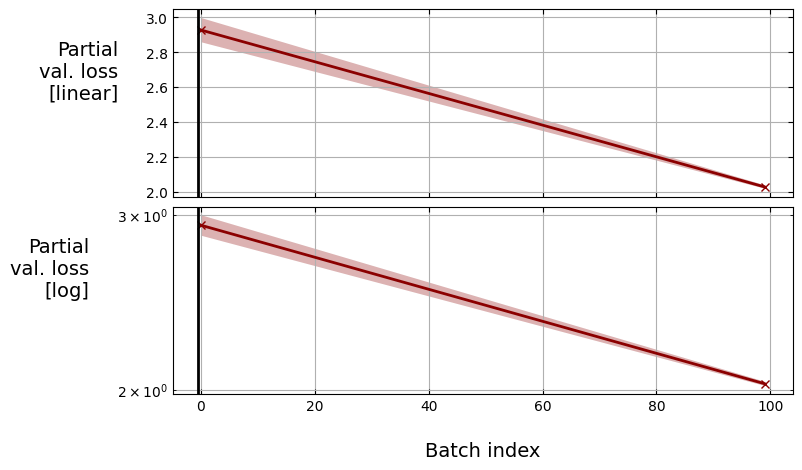

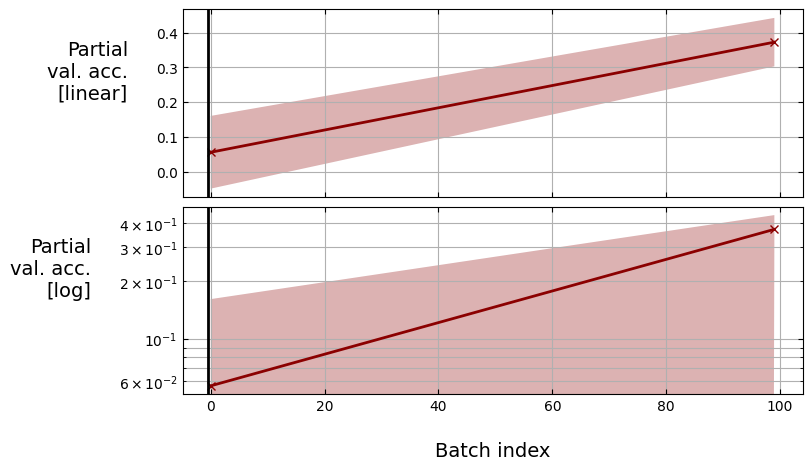

 298/1981 [===>..........................] - ETA: 1:27 - loss: 1.6619 - masked_accuracy: 0.4669

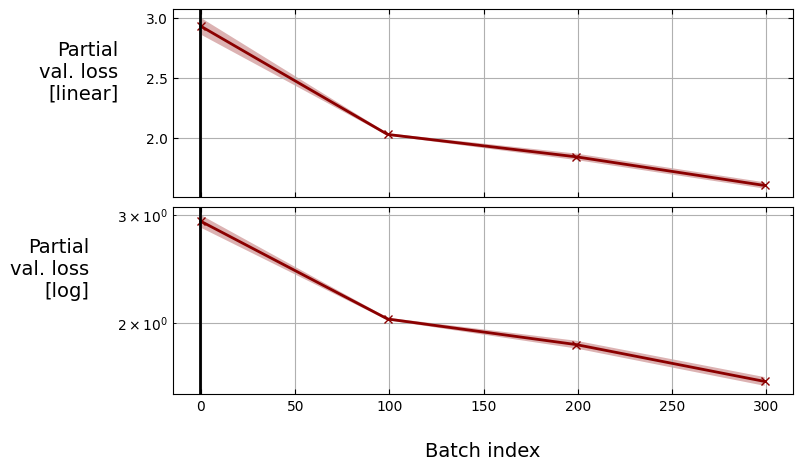

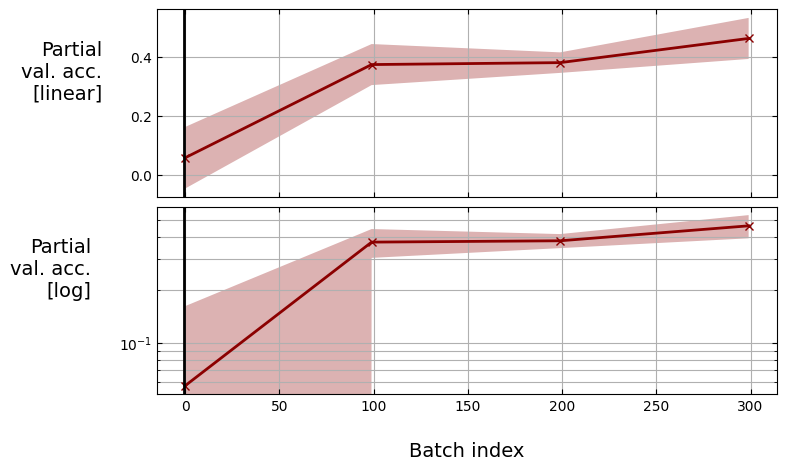

 499/1981 [======>.......................] - ETA: 1:25 - loss: 1.5901 - masked_accuracy: 0.4763

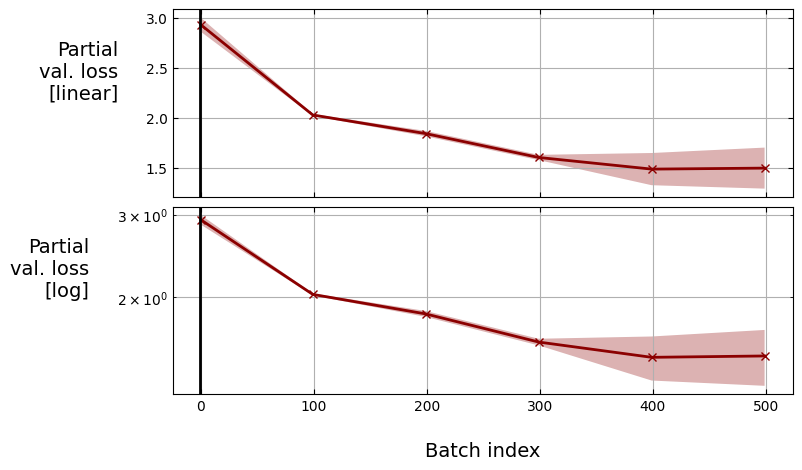

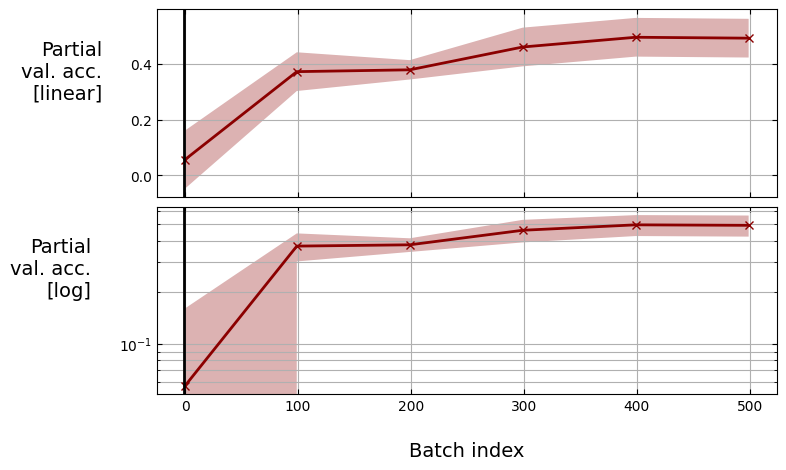

 561/1981 [=======>......................] - ETA: 1:24 - loss: 1.5739 - masked_accuracy: 0.4786

In [ ]:
##=================##
##   Train model   ##
##=================##


##  Fit the model if configured
if global_config.get("training",{}).get("train",True) :
    max_epochs = global_config["training"]["max_epochs"]
    batch_size = global_config["training"]["batch_size"]
    
    logger.info(f"Begin model training with max_epochs={max_epochs}, batch_size={batch_size}")
    model.fit([train_X, train_Y_in], 
              train_Y_out,
              epochs          = max_epochs,
              batch_size      = batch_size,
              validation_data = ([val_X, val_Y_in], val_Y_out),
              callbacks       = callbacks
             )
else :
    logger.warning("Skipping model training following global config instructions")


In [ ]:
##================##
##   Save model   ##
##================##

save_fname = f"{working_dir}/final_model.h5"
model.save(save_fname)
logger.info(f"Model save to file {save_fname}")


## 6.  Evaluate model

In [ ]:

class Transformer_Seq_to_Seq :
    
    def __init__(self, model:Model, tokeniser_dict:dict, detokeniser_dict:dict, mask_char:str, seq_start_char:str, 
                 seq_end_char:str, input_dtype=None) :
        """
        class Transformer_Seq_to_Seq
        
        Wrapper for sequence-to-sequence model that allows easy transform operations
        
        Input:
        
            >  model, Model
               Sequence-to-sequence keras model
            
            >  tokeniser_dict, dict
               Dictionary of character:token pairs
               
            >  detokeniser_dict, dict
               Dictionary of token_character pairs
               
            >  mask_char, str of length 1
               Masking character
               
            >  seq_start_char, str of length 1
               Special character denoting the start of a sequence
               
            >  seq_end_char, str of length 1
               Special character denoting the end of a sequence
               
            >  input_dtype, tf dtype compatible, default=None
               dtype of input data tensors
        """
        self.model            = model
        self.tokeniser_dict   = tokeniser_dict
        self.detokeniser_dict = detokeniser_dict
        self.mask_char        = mask_char
        self.seq_start_char   = seq_start_char
        self.seq_end_char     = seq_end_char
        self.input_dtype      = input_dtype
        

    def transform_from_data_tensor(self, X, max_tokens:int=-1, device:str="CPU") :
        """
        Transform a tensor of input data into its predicted output string using argmax to select tokens
        
        Inputs:
        
            >  X, Tensor with final dimensions [S, 2]
               Tensor of (token, index) pairs for the input sequence of length S
               
            >  max_tokens, int, default=-1
               Maximum tokens in sequence
               
            >  device, str, default="CPU"
               Device to run tensorflow on
        """
        ##  Recurse over tensor of inputs
        if len(X.shape) > 1 and X.shape[0] > 1 :
            return [self.transform_from_data_tensor(Xp, max_tokens, device) for Xp in X]
        
        ##  Check arguments
        if max_tokens > 0 and max_tokens < 3 :
            raise ArgumentError(f"max_tokens must have a minimum length of 3, {max_tokens} provided")
        
        ##  If no internal dtype chosen then fall back to X.dtype
        dtype = self.input_dtype
        if not dtype : dtype = X.dtype
        
        ##  If X is shape [S, F] then reshape it to [B, S, F] with B=1
        one_sequence_provided = len(X.shape) == 1
        if one_sequence_provided :
            X = X[tf.newaxis, :]
            
        #  Find tokens for start and end characters
        start_token = self.tokeniser_dict[self.seq_start_char]
        end_token   = self.tokeniser_dict[self.seq_end_char  ]

        ##  Select tf device
        with tf.device(device) :

            ##  Create initial sequence with shape [1, 1] and features [[seq_start_char]]
            Y = tf.cast([[start_token]], dtype=dtype)

            ##  Keep generating tokens until we reach an end character, or the token limit
            best_token, num_tokens = start_token, 1
            while best_token != end_token and (max_tokens <= 0 or num_tokens < max_tokens) :
                
                ##  Generate logit predictions for all indices; slice logits for first sequence & final index
                token_logits = model([X, Y])[0,-1]
                
                ##  Use argmax operation to interpret the predicted token
                best_token   = np.argmax(token_logits.numpy(), axis=-1)
                
                ##  Append new token to the list
                Y = tf.concat([Y, tf.constant([[best_token]], dtype=dtype)], axis=1)
                
                ##  Iterate forwards num_tokens
                num_tokens += 1

        ##  Convert tensor-of-tokens-and-indices Y into a string of detokenised characters
        out_str = "".join([self.detokeniser_dict[t] for t in Y.numpy()[0]])
        out_str = out_str[1:]
        if out_str[-1] == self.seq_end_char : out_str = out_str[:-1]
            
        ##  Return string with same format as input
        return out_str if one_sequence_provided else [out_str]
    
    
    def transform_from_string(self, X, max_tokens:int=-1, device:str="CPU") :
        """
        Transform a list of input strings into their predicted output string using argmax to select tokens
        
        Inputs:
        
            >  X, string or list of strings
               String(s) to be transformed
               
            >  max_tokens, int, default=-1
               Maximum tokens in sequence
               
            >  device, str, default="CPU"
               Device to run tensorflow on
        """
        
        ##  Cast data to list format
        one_string_provided = type(X) == str
        if one_string_provided : X = [X]
                     
        ##  If no dtype set internally then fall back to using tf.int32   
        dtype = self.input_dtype
        if not dtype : dtype = tf.int32
        
        ##  Figure out the maximum sequence length of the inputs to determine tensor dims
        fix_output_length = max([len(x) for x in X]) + len(self.seq_start_char) + len(self.seq_end_char)
                
        ##  Create tensor of input data
        X = strings_to_tensor(X, self.tokeniser_dict, fix_output_length=fix_output_length, 
                              mask_char=self.mask_char, seq_start_char=self.seq_start_char, 
                              seq_end_char=self.seq_end_char, add_position_indices=False, dtype=dtype)
        
        ##  Predict outputs from tensor input
        Y = self.transform_from_data_tensor(X, max_tokens=max_tokens, device=device)
        
        ##  Return strings with same format as input
        return Y[0] if one_string_provided else Y
    
    
transformer = Transformer_Seq_to_Seq(model, tokeniser_dict, detokeniser_dict, mask_char, seq_start_char, seq_end_char)


In [ ]:
##====================================##
##   Evaluate model using test data   ##
##====================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Log table header
logger.info("Evaluating text --> text mathsformer on the test set:")
logger.info("-"*50)
logger.info("INPUT".rjust(12) + "TRUE".rjust(8) + "PRED".rjust(8) + "CORRECT".rjust(10) + "RESIDUAL".rjust(10))
logger.info("-"*50)

##  Get model predictions and log alongside true labels 
for x, x_str, true_y_str in zip(test_X[:num_print], 
                     detokenise_strings(test_X[:num_print,:].numpy(), detokeniser_dict, mask_char=mask_char, 
                                        seq_start_char=seq_start_char, seq_end_char=seq_end_char),
                     detokenise_strings(test_Y_out[:num_print].numpy(), detokeniser_dict, mask_char=mask_char, 
                                        seq_start_char=seq_start_char, seq_end_char=seq_end_char)
                    ) :
    pred_y_str = transformer.transform_from_data_tensor(x, max_tokens=20)
    result     = "  X" if pred_y_str == true_y_str else ""
    try    : residual = str(int(pred_y_str.replace("N","-")) - int(true_y_str.replace("N","-")))
    except : residual = "N/A"
    logger.info(x_str.rjust(12) + true_y_str.rjust(8) + pred_y_str.rjust(8) + result.rjust(8) + residual.rjust(10))


In [ ]:
##======================================================================================##
##   Evaluate model using random numbers with lengths not experienced during training   ##
##======================================================================================##

##  Find out how many datapoints to print predictions for 
num_print = int(global_config.get("evaluate",{}).get("num_print", 20))

##  Find out the maximum number of digits to allow per input number (= 2 higher than maximum input length)
max_char = math.floor(math.log10(max_int)) + 2

##  Log table header
logger.info(f"Evaluating text --> text mathsformer on randomly generated strings with max number length of {max_char}:")
logger.info("-"*70)
logger.info("INPUT".rjust(15) + "TRUE".rjust(15) + "PRED".rjust(15) + "RESIDUAL".rjust(15))
logger.info("-"*70)

for i in range(num_print) :
    m1, m2 = np.random.randint(low=1, high=max_char+1, size=(2,))
    n1, n2 = np.random.randint(low=10**(m1-1), high=10**m1), np.random.randint(low=10**(m2-1), high=10**m2)
    s1, s2 = np.random.choice([-1, 1], size=(2,))
    n1, n2 = s1*n1, s2*n2
    s1, s2 = str(n1).replace("-","N"), str(n2).replace("-","N")
    op = np.random.choice(["+", "-"])
    if op == "+" : answer = n1 + n2
    if op == "-" : answer = n1 - n2
    query = f"{s1}{op}{s2}"
    guess = transformer.transform_from_string(query).replace("N","-")
    residual = str(int(guess) - answer)
    logger.info(query.rjust(15) + str(answer).rjust(15) + guess.rjust(15) + residual.rjust(15))



##  7. Additional visualisations

In [ ]:
##==========================##
##   Visualise loss curve   ##
##==========================##

if len(loss_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    loss_record.plot()
    

In [ ]:
##=============================================##
##   Visualise layer weights during training   ##
##=============================================##

if len(layer_weights_record.batch_indices) == 0 :
    logger.warning("Not plotting layer weights because no data found")
else :
    logger.info("Plotting layer weights")
    layer_weights_record.plot(num_col=6)
    